The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4



.........................initialize..........................
FileName: infer2018/infer2018_BA_identical_16_4_-1_0_100_100.0_100000
Strains: 4
Using BA random graph model
Num of nodes: 100
Num of links: 384
Reverse ZERO: tensor(5.3551e-07)
Num links weight bigger than 0.2: tensor(0)
Num links weight bigger than 0.1: tensor(0)
Num links weight bigger than 0.01: tensor(393)
.............................................................


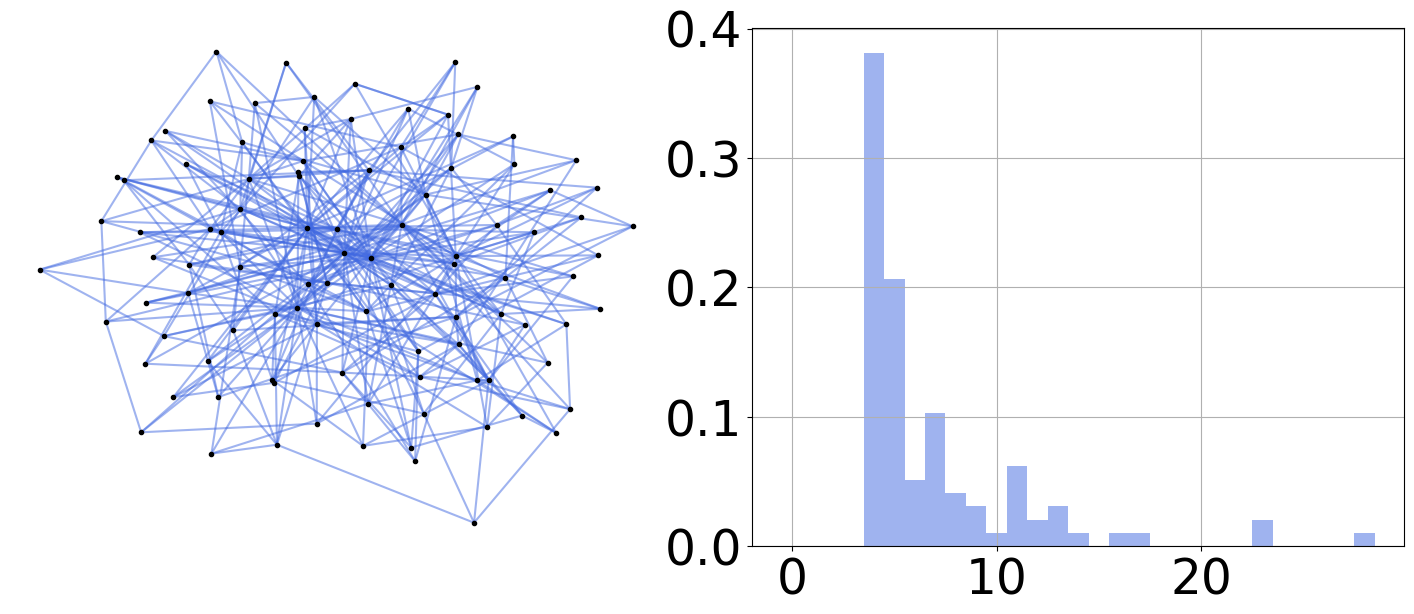

In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import modules.random_graph as random_graph
import logging
import modules.weight as weight
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.population as population
import modules.plotGraph as plotGraph
import modules.simulation as simulation
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import math

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "infer2018"

#realGraphs= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]
realGraphs2= ["global_air", "us_air"]
realGraphs3= ["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_car", "spain_plane", "spain_train"]
paras.randomGraph= "BA"
paras.weightModel= "identical"
paras.epoches= 100000
paras.intense= -1
paras.seed= 16
paras.plot= "spring"
paras.strains= 4
paras.dense= 0
paras.identicalf= 0.01
paras.n= 100
# paras.R0Std= 1
# paras.tauStd= 1


# paras.epoches= 50000
# paras.randomGraph= "ER"
# paras.weightModel= "identical"
# paras.seed= 20
#paras.dense= 8


random.seed(paras.seed)

#results and logs file name
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}\
_{paras.intense}_{paras.dense}_{paras.n}_{paras.identicalf*10000}_{paras.epoches}"

printFlag= 1
if printFlag!=1:
    logging.basicConfig(filename="logs/"+paras.modelLoad+".out", level=logging.INFO)

plotFlag= 1

device= paras.device if torch.cuda.is_available() else "cpu"

P= population.population(paras.n, device= device)

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    utils.log_print(printFlag, paras.dense)

# generate random graphs: RGG(defult), ER, WS, BA'
if paras.randomGraph=="RGG":
    A, G, pos= random_graph.get_RGG_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="BA":
    A, G= random_graph.get_BA_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="WS":
    A, G= random_graph.get_WS_random_contact(paras.n, paras.dense*2, paras.wsProbability, device= device)
elif paras.randomGraph=="ER":
    A, G= random_graph.get_ER_random_contact(paras.n, paras.dense, device= device)
else:
    A, G= random_graph.read_from_file("graphs/"+paras.randomGraph+".npy")
    paras.n= A.shape[0]
    if A.diagonal().sum()> paras.n+1:
        Pop= A.sum(axis=0)+A.sum(axis=1)-A.diagonal()+1e-5
        A= A/Pop
        A= A.fill_diagonal_(0)
        P= torch.tensor(Pop, device= device)
        G = nx.from_numpy_array((A>0.002).numpy())
    else:
        P= population.population(paras.n, device= device)


#assign adjacency weight to matrix: degree(defult), gravity

if paras.weightModel=="degree":
    Aw= weight.degree_model(A, P= P, device=device)
elif  paras.weightModel=="gravity":
    Aw= weight.gravity_model(G, pos, P, device= device)
elif  paras.weightModel=="identical":
    Aw= weight.identical_model(A, paras.identicalf, device= device)
elif  paras.weightModel=="none":
    Aw= A.to(device= device)

utils.log_print(printFlag,"\n\n\n.........................initialize..........................")
utils.log_print(printFlag,"FileName:", fileName)
utils.log_print(printFlag,"Strains:", paras.strains)
utils.log_print(printFlag,"Using", paras.randomGraph,"random graph model")
utils.log_print(printFlag,"Num of nodes:", G.number_of_nodes())
utils.log_print(printFlag,"Num of links:", G.number_of_edges())
Zmat= A_mat.create_A_mat(Aw, P)
Zmat2= A_mat.reverse_A_mat(Zmat-torch.eye(Aw.shape[0], dtype= torch.float32, device= Aw.device), P)
utils.log_print(printFlag,"Reverse ZERO:", torch.sum(torch.abs(Zmat2-Aw)))
utils.log_print(printFlag,"Num links weight bigger than 0.2:", torch.sum(Zmat>0.2)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.1:", torch.sum(Zmat>0.1)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.01:", torch.sum(Zmat>0.01)-paras.n)
utils.log_print(printFlag,".............................................................")
#plot this network
if plotFlag==1:
    if paras.plot== "2d_RGG":
        plotGraph.plot_2d_RGG(G, pos)
    elif paras.plot== "spring":
        plotGraph.plot_spring_and_degree(G)

[8.057129150061598, 7.920464021311062, 7.8516519717856506, 8.04512538212544, 8.320881817904473, 8.770078196447283, 8.147752141823155, 8.152904037231899, 8.137829726685991, 8.105962385580817, 8.609813857916238, 8.41349857391642, 8.443944284910348, 7.932094374830619, 8.352721680594518, 8.359308116324113, 7.9998516962427475, 8.017966211589052, 8.397050722401955, 8.004156735104615, 8.088538553071423, 8.754229323449632, 8.592899196211413, 8.637998200644242, 8.033579580750716, 8.607519269578548, 7.904644112391576, 8.470636602490737, 7.947924676434896, 8.237129470420715, 8.36227970243038, 8.499460538835352, 8.1954296765102, 8.392197689550326, 8.037290341689832, 8.516940895865822, 7.908064651098907, 8.290485529280629, 8.043898678028773, 8.610536219341403]
[7.565575275347795, 7.416104369607118, 7.5263978823955116, 7.453756785985218, 7.546379059979874, 7.411948023474744, 7.403064212528716, 7.53319709497917, 7.485805102455336, 7.596101666395012, 7.577716024505148, 7.578805304477859, 7.41848368434

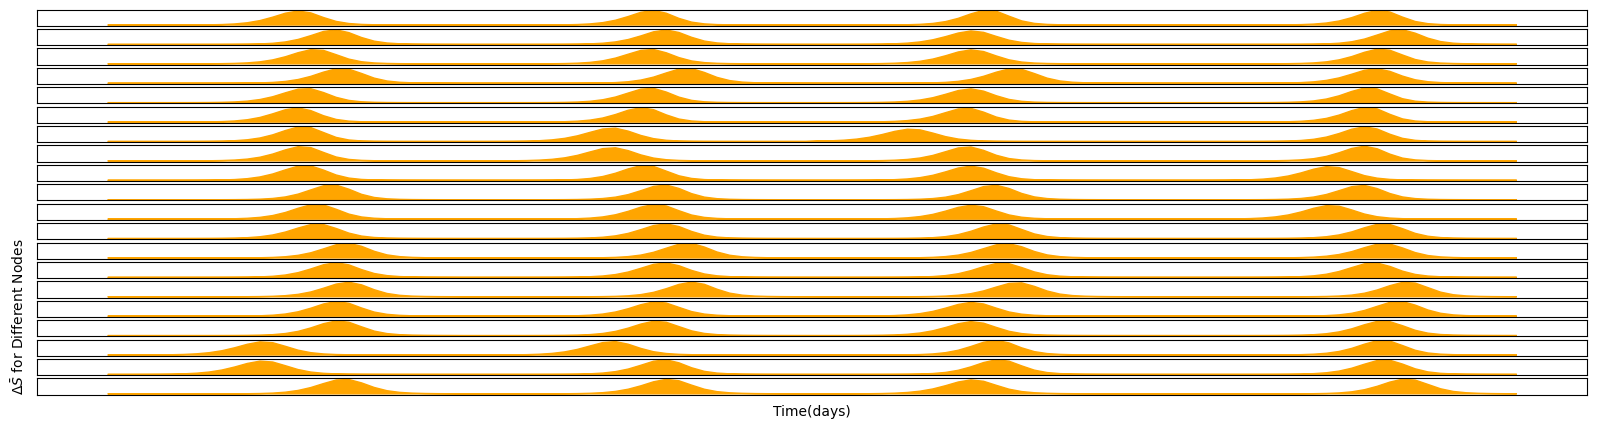

In [21]:
R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]
utils.log_print(printFlag,paras.R0s)
utils.log_print(printFlag,paras.taus)
deltaSsTensor, randomList= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 20, device= device)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)


utils.log_print(printFlag,divide.shape)
if plotFlag==1:
    numPlot= 20
    fig, axs = plt.subplots(numPlot, 1, figsize=(20, 5))
    
    for i, ax in enumerate(axs):
        ax.fill(divide[i, :].T.cpu().detach().T.reshape(-1),  color='orange')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_ylabel(f"{i}")
    plt.ylabel(r"$\Delta \bar S$ for Different Nodes",  loc='bottom')
    plt.xlabel("Time(days)")
    
    
    #plt.title(f"Example of {numPlot} nodes epidemic newly infected.")
print(divide[i, :].shape)

torch.Size([100, 4, 28])


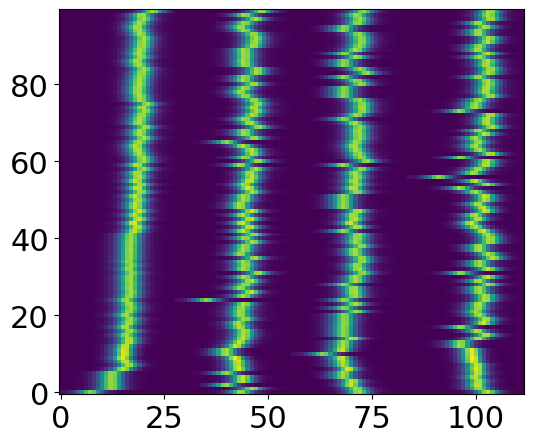

In [22]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)
nodes_diantance_index= rank_nodes_by_distance(G, randomList[0])

shapeY= divide.shape[0]
shapeX= divide.shape[1]*divide.shape[2]
divide2D= divide.reshape(shapeY, shapeX).cpu().detach()
heatMapDivide2D= divide2D[nodes_diantance_index, :]
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), heatMapDivide2D)
#cbar= fig.colorbar(cmap)

#cbar.ax.tick_params(labelsize= fontsize-7)

# plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

# plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)


plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [48]:

timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 24,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 24,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 3,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=1e-3)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr=1e-3)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=1e-3)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)

def evaluate_epoch(preZ, methods= []):
    IMatrix= torch.eye(paras.n, device= device)
    preA= A_mat.reverse_A_mat(preZ-IMatrix, P)
    oneResult= []
    for method in methods:
        oneResult.append(method(Aw.cpu(), preA.cpu()))
    return oneResult
evaluateResults= []
sensetives= []

In [49]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]

if paras.modelLoad== "infer2018":
    for j in tqdm(range(paras.epoches)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        tempEye= torch.eye(paras.n, device= device)

        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()+1e-4*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))
        losses.append((loss-1e-4*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))).item())
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        if j%paras.evaluateEvery== 0:
            evaluateResults.append(evaluate_epoch(PreZ.detach(), evaluateMeth))
else:
    for j in tqdm(range(paras.epoches-50000)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        if j%paras.evaluateEvery== 0:
            Apart= myMatch.Wnorm(myMatch.Atemp).squeeze()
            Bpart= myMatch.AmatBias
            sensitiveA= (myMatch.mySig(Apart)*myMatch.mySig(1-Apart)).sum()
            sensitiveB= (myMatch.mySig(Bpart)*myMatch.mySig(1-Bpart)).sum()
            sensetives.append([sensitiveA.item(), sensitiveB.item()])
            evaluateResults.append(evaluate_epoch(PreZ.detach(), evaluateMeth))

 89%|████████▉ | 89091/100000 [18:26<02:15, 80.51it/s]


KeyboardInterrupt: 

In [50]:
torch.sum((PreZ-tempEye), dim= 1)

tensor([23.2542, 21.7950, 20.1370, 18.0121, 16.4216, 36.4799, 23.4773, 29.3003,
        27.2974, 23.4759, 10.3849, 15.4656, 15.3006, 14.1792, 16.8613, 22.7531,
        20.8580, 18.8286, 14.5033, 16.9360, 19.6425, 17.6049, 27.3367, 17.6086,
        20.5981, 17.9811, 15.5656, 17.4945, 13.1574, 20.9749, 13.9880, 16.5053,
        24.8782, 16.2684, 20.5568, 14.1745, 20.6997, 15.8552, 13.9407, 16.0734,
        19.5024, 18.2179, 17.7106, 17.6780, 15.3220, 14.0800, 12.6939, 16.4883,
        17.3197, 17.3056, 18.1402, 16.4532, 15.1242, 14.7004, 15.7241, 21.0492,
        18.9830, 15.5238, 17.3253, 16.7208, 17.6612, 16.7877, 17.6678, 17.3065,
        14.8769, 20.5809, 20.8429, 16.8346, 13.7518, 16.4098, 17.5343, 17.7083,
        16.0662, 24.1281, 17.2944, 16.1763, 13.1367, 16.4575, 13.2189, 20.4053,
        17.8426, 17.2267, 17.1950, 13.8799, 17.0141, 14.2224, 16.9086, 16.5042,
        17.1374, 15.7687, 16.7199, 16.0622, 19.7944, 24.6897, 15.7096, 15.8513,
        14.3708, 17.4926, 16.9310, 16.48

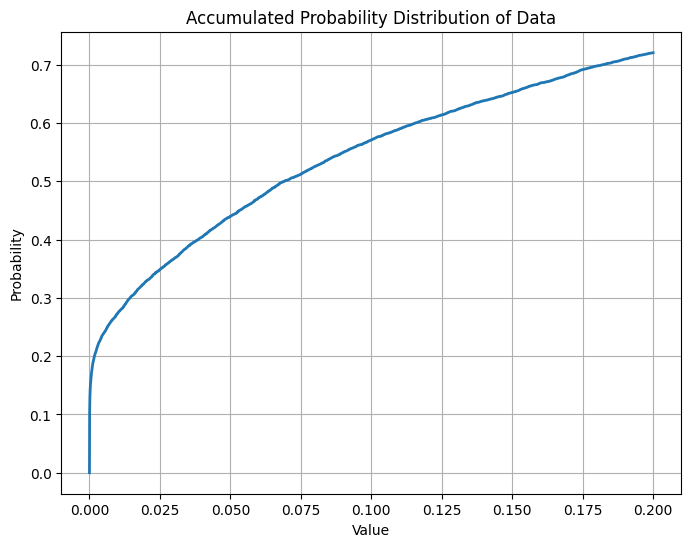

In [51]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()

pxs= []
pys= []
# Compute histogram
for i in range(10000):
    px= i/1000/50
    py= np.sum(inferZmatNp<px)/10000
    pxs.append(px)
    pys.append(py)
    pass

# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

In [52]:

#save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
utils.log_print(printFlag,paras.taus[0: paras.strains])
utils.log_print(printFlag,paras.R0s[0: paras.strains])
utils.log_print(printFlag,myEpi.taus[0])
utils.log_print(printFlag,(myEpi.taus*myEpi.R0dTaus)[0])

IMatrix= torch.eye(paras.n, device= device)
PreA= A_mat.reverse_A_mat(PreZ-IMatrix, P)


evaluateResults.append(evaluate_epoch(PreZ.squeeze().detach(), evaluateMeth))


utils.log_print(printFlag,"spectral_similarity:", evaluateResults[-1][0])
utils.log_print(printFlag,"pearson_correlation:", evaluateResults[-1][1])
utils.log_print(printFlag,"jaccard_similarity:", evaluateResults[-1][2])
utils.log_print(printFlag,"ROC_AUC:", evaluateResults[-1][3])
utils.log_print(printFlag,"PR_AUC:", evaluateResults[-1][4])
utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))
utils.log_print(printFlag,torch.var(myEpi.R0dTaus, dim= 0))
startV= 5
deltaV= 7
utils.log_print(printFlag,PreA[startV:startV+deltaV, startV:startV+deltaV])
utils.log_print(printFlag,Aw[startV:startV+deltaV, startV:startV+deltaV])
np.savez("results/"+fileName+".npz", A= Aw.cpu().detach(), Apre= PreA.cpu().detach(), 
         cosine_similarity= evaluate.cosine_similarity(Aw, PreA).item(),
         loss= losses, taus= paras.taus, r0s= paras.R0s, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach(),
           evaluates= evaluateResults)


[7.565575275347795, 7.416104369607118, 7.5263978823955116, 7.453756785985218]
[8.057129150061598, 7.920464021311062, 7.8516519717856506, 8.04512538212544]
tensor([8.2294, 7.8579, 8.4210, 8.3634], grad_fn=<SelectBackward0>)
tensor([ 4.5315,  0.3537,  2.7191, -0.4984], grad_fn=<SelectBackward0>)
spectral_similarity: tensor(0.2782)
pearson_correlation: tensor(0.0205)
jaccard_similarity: tensor(0.0031)
ROC_AUC: 0.41650039058478716
PR_AUC: 0.08685911058012409
tensor([3.9740e-06, 4.0474e-06, 2.2150e-06, 2.1949e-06],
       grad_fn=<VarBackward0>)
tensor([0.0353, 0.0290, 0.0217, 0.0230], grad_fn=<VarBackward0>)
tensor([[0.0000e+00, 2.1942e-02, 7.4100e-01, 1.3775e-07, 9.6928e-01, 2.6605e-02,
         2.1712e-07],
        [1.0598e-01, 0.0000e+00, 2.3586e-05, 5.1836e-01, 9.7307e-01, 4.9467e-06,
         3.8508e-06],
        [1.3503e-01, 1.6035e-02, 0.0000e+00, 6.3908e-01, 9.7291e-01, 1.3793e-06,
         7.5670e-07],
        [3.8343e-02, 1.3326e-02, 3.4937e-01, 0.0000e+00, 7.7643e-07, 1.7140e-02

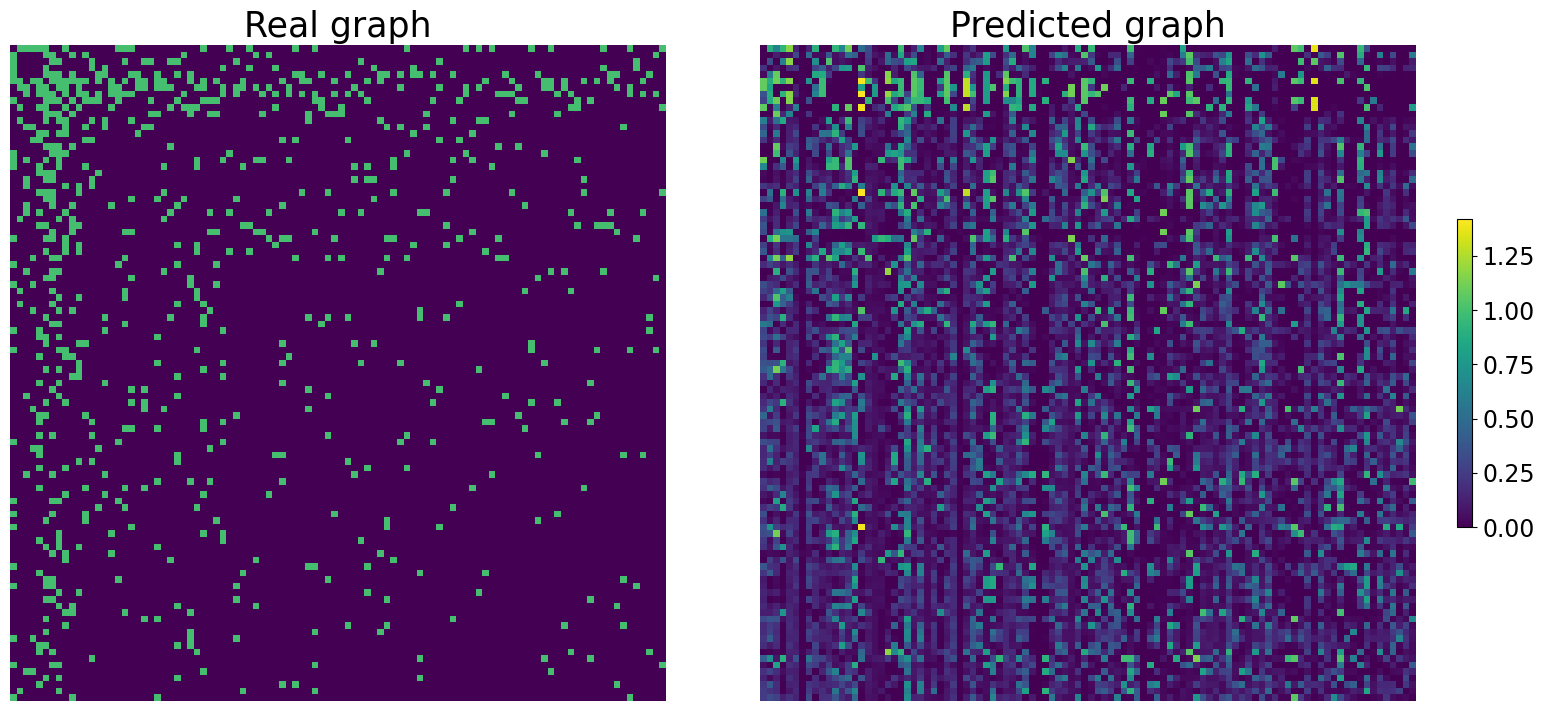

In [53]:
if plotFlag==1:
    plotGraph.plot_adjacenty(A.cpu().detach().numpy(), [ PreA.cpu().detach().numpy()])

In [70]:
Apart= myMatch.Wnorm(myMatch.Atemp).squeeze()
Bpart= myMatch.AmatBias
print(Apart.max())
print((myMatch.mySig(Apart)*myMatch.mySig(1-Apart)).sum())
print((myMatch.mySig(Bpart)*myMatch.mySig(1-Bpart)).sum())
print(torch.var(Apart))
print(torch.mean(Apart))
print(torch.var(Bpart))
print(torch.mean(Bpart))

AttributeError: 'matchingB' object has no attribute 'Wnorm'

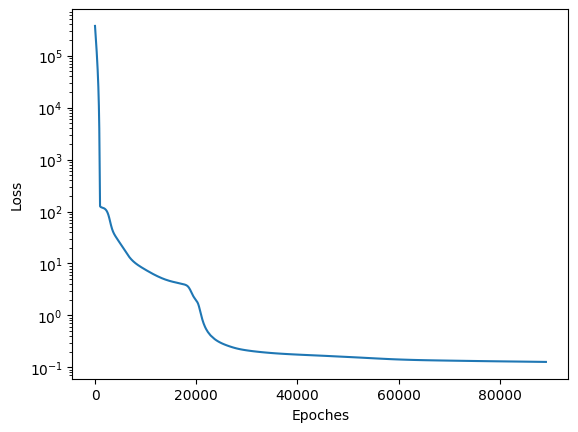

In [54]:
if plotFlag==1:
    plt.plot(losses)
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")

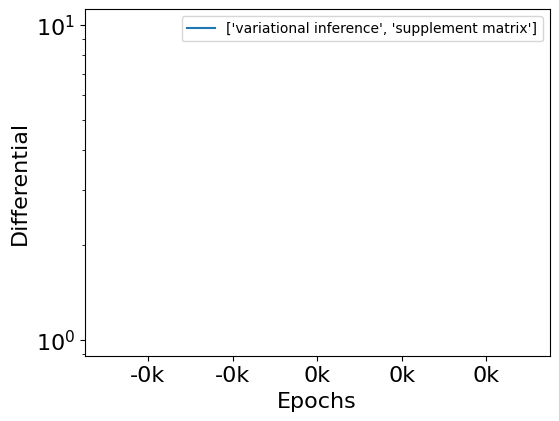

In [73]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([i*100 for i,_ in enumerate(sensetives)], sensetives, label=["variational inference", "supplement matrix"])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}k'.format(x*1e-3)))
ax.set_xlabel("Epochs", fontsize= 16)
ax.set_ylabel("Differential", fontsize= 16)
ax.set_yscale("log")
ax.tick_params(axis='both', labelsize=16)
ax.legend()

tensor(0.)
tensor(9.6984e-10, grad_fn=<SelectBackward0>)
torch.Size([100, 4, 28])


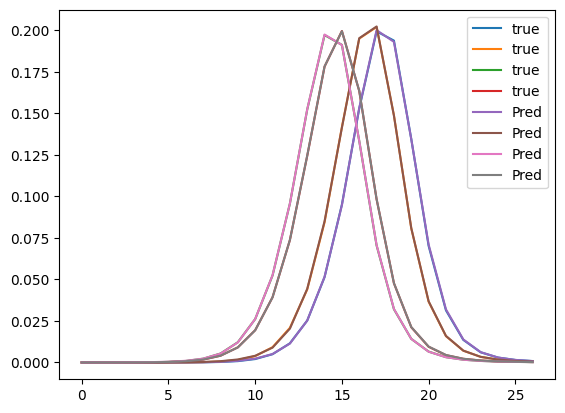

In [55]:
if plotFlag==1:
    node= 3
    plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=paras.strains*["true"])
    utils.log_print(printFlag,signal[node, 0, 1])
    utils.log_print(printFlag,predSignal[node, 0, 0])
    #plt.plot(embedded_tensor[0, :, -1:].squeeze().T.cpu().detach())
    plt.plot(predSignal[node, :, 0:-1].squeeze().T.cpu().detach(), label=paras.strains*["Pred"])
    #plt.plot(noise[0].T.cpu().detach())
    plt.legend()
    print(signal.shape)